In [39]:
import os
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

from fastai.tabular import *
from fastai.callbacks import SaveModelCallback
from fastai.basic_data import DataBunch

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [40]:
# __print__ = print
# def print(*strings):
#     for string in strings:
#         os.system(f'echo \"{string}\"')
#         __print__(string)

## Define some constants

In [74]:
FOLD_ID = 2
VERSION = 2

TYPES              = np.array(['1JHC', '2JHH', '1JHN', '2JHN', '2JHC', '3JHH', '3JHC', '3JHN'])
TYPES_MAP          = {t: i for i, t in enumerate(TYPES)}
SC_EDGE_FEATS      = ['type_0', 'type_1', 'type_2', 'type_3', 'type_4', 'type_5', 'type_6', 'type_7', 
                      'dist', 'dist_min_rad', 'dist_electro_neg_adj', 'normed_dist', 
                      'diangle', 'cos_angle', 'cos_angle0', 'cos_angle1', 
                      #'inv_dist', 'normed_inv_dist'
                     ]
SC_MOL_FEATS       = ['type_0', 'type_1', 'type_2', 'type_3', 'type_4', 'type_5', 'type_6', 'type_7', 
                      'dist', 'dist_min_rad', 'dist_electro_neg_adj', 'normed_dist', 
                      'diangle', 'cos_angle', 'cos_angle0', 'cos_angle1', 
                      'num_atoms', 'num_C_atoms', 'num_F_atoms', 'num_H_atoms', 'num_N_atoms', 'num_O_atoms', 
                      #'inv_dist', 'normed_inv_dist', 
                      'std_bond_length', 'ave_bond_length', #'total_bond_length',  
                      #'ave_inv_bond_length', 'total_inv_bond_length', 
                      'ave_atom_weight'#, 'total_atom_weight'
                     ]
ATOM_FEATS         = ['type_H', 'type_C', 'type_N', 'type_O', 'type_F', 
                      'degree_1', 'degree_2', 'degree_3', 'degree_4', 'degree_5', 
                      'SP', 'SP2', 'SP3', 'hybridization_unspecified', 
                      'aromatic', 'formal_charge', 'atomic_num',
                      'donor', 'acceptor', 
                      'ave_bond_length', 
                      #'ave_inv_bond_length',
                      'ave_neighbor_weight']
EDGE_FEATS         = ['single', 'double', 'triple', 'aromatic', 
                      'conjugated', 'in_ring',
                      'dist', 'normed_dist', 
                      #'inv_dist', 'normed_inv_dist'
                     ]
TARGET_COL         = 'scalar_coupling_constant'
CONTRIB_COLS       = ['fc', 'sd', 'pso', 'dso']
N_EDGE_FEATURES    = len(EDGE_FEATS)
N_SC_EDGE_FEATURES = len(SC_EDGE_FEATS)
N_SC_MOL_FEATURES  = len(SC_MOL_FEATS)
N_ATOM_FEATURES    = len(ATOM_FEATS)
N_TYPES            = len(TYPES)
N_MOLS             = 130775
SC_MEAN            = 16
SC_STD             = 35

SC_FEATS_TO_SCALE   = ['dist', 'dist_min_rad', 'dist_electro_neg_adj', 'num_atoms', 'num_C_atoms', 
                       'num_F_atoms', 'num_H_atoms', 'num_N_atoms', 'num_O_atoms', 'inv_dist', 
                       'ave_bond_length', 'std_bond_length', 'total_bond_length',  'ave_inv_bond_length', 
                       'total_inv_bond_length', 'ave_atom_weight', 'total_atom_weight']
ATOM_FEATS_TO_SCALE = ['atomic_num', 'ave_bond_length', 'ave_inv_bond_length', 'ave_neighbor_weight']
EDGE_FEATS_TO_SCALE = ['dist', 'inv_dist']

## Import data

In [42]:
DATA_PATH = '../data/'
PATH = '../tmp/'
CV_IDXS_PATH = PATH
# DATA_PATH = '../input/champs-scalar-coupling/'
# PATH = '../input/champs-processed-data-3/'
# CV_IDXS_PATH = '../input/champs-cv-4-fold-idxs/'

In [43]:
def show_csv_files(path):
    files = os.listdir(path)
    files = [f for f in files if f.find('.csv') != -1]
    print(f'{path}:', files)
show_csv_files(PATH)
show_csv_files(DATA_PATH)
# show_csv_files(CV_IDXS_PATH)

../tmp/: ['atomic_features.csv', 'angle_out_df.csv', 'train_proc_df.csv', 'mask.csv', 'train_idxs_8_fold_cv.csv', 'edge_mask.csv', 'atom_df.csv', 'pairs_idx.csv', 'edge_df.csv', 'train_idxs_4_fold_cv.csv', 'edge_features.csv', 'dist_df.csv', 'angle_in_df.csv', 'angle_df.csv', 'val_idxs_8_fold_cv.csv', 'val_idxs_4_fold_cv.csv', 'test_proc_df.csv']
../data/: ['scalar_coupling_contributions.csv', 'mulliken_charges.csv', 'structures.csv', 'test.csv', 'train.csv', 'magnetic_shielding_tensors.csv', 'dipole_moments.csv', 'sample_submission.csv', 'potential_energy.csv']


In [44]:
train_df = pd.read_csv(PATH+'train_proc_df.csv', index_col=0)
test_df  = pd.read_csv(PATH+'test_proc_df.csv', index_col=0)
atom_df  = pd.read_csv(PATH+'atom_df.csv', index_col=0)
edge_df  = pd.read_csv(PATH+'edge_df.csv', index_col=0)
dist_df  = pd.read_csv(PATH+'dist_df.csv', index_col=0, dtype=np.float32)
angle_in_df  = pd.read_csv(PATH+'angle_in_df.csv', index_col=0)
angle_out_df = pd.read_csv(PATH+'angle_out_df.csv', index_col=0)

train_mol_ids = pd.read_csv(CV_IDXS_PATH+'train_idxs_8_fold_cv.csv', usecols=[0, FOLD_ID], index_col=0).dropna().astype(int).iloc[:,0]
val_mol_ids   = pd.read_csv(CV_IDXS_PATH+'val_idxs_8_fold_cv.csv', usecols=[0, FOLD_ID], index_col=0).dropna().astype(int).iloc[:,0]
test_mol_ids  = pd.Series(test_df['molecule_id'].unique())

contribs_df = pd.read_csv(DATA_PATH+'scalar_coupling_contributions.csv')
train_df = pd.concat((train_df, contribs_df[CONTRIB_COLS]), axis=1)
del contribs_df
gc.collect()

train_df[[TARGET_COL, 'fc']] = (train_df[[TARGET_COL, 'fc']] - SC_MEAN) / SC_STD
train_df[CONTRIB_COLS[1:]] = train_df[CONTRIB_COLS[1:]] / SC_STD

train_df['num_atoms'] = train_df[['num_C_atoms', 'num_F_atoms', 'num_H_atoms', 
                                  'num_N_atoms', 'num_O_atoms']].sum(axis=1)
test_df['num_atoms'] = test_df[['num_C_atoms', 'num_F_atoms', 'num_H_atoms', 
                                'num_N_atoms', 'num_O_atoms']].sum(axis=1)
train_df[['num_atoms', 'num_C_atoms', 'num_F_atoms', 'num_H_atoms', 'num_N_atoms', 'num_O_atoms']] /= 10
test_df[['num_atoms', 'num_C_atoms', 'num_F_atoms', 'num_H_atoms', 'num_N_atoms', 'num_O_atoms']] /= 10

/anaconda2/envs/python36/lib/python3.6/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [45]:
train_df.head()

,atom_0,atom_1,atom_index_0,atom_index_1,cos_angle,cos_angle0,cos_angle1,diangle,dist,dist_electro_neg_adj,...,std_bond_length,total_bond_length,ave_inv_bond_length,total_inv_bond_length,ave_atom_weight,total_atom_weight,fc,sd,pso,dso
0,H,C,1,0,0.000000,0.000000,-0.333335,0.0,1.091953,2.593389,...,0.000003,4.367799,0.915793,3.663173,0.2,1.0,1.914926,0.007274,0.035961,0.007772
1,H,H,1,2,-0.333287,0.816483,0.816482,0.0,1.783120,3.922863,...,0.000003,4.367799,0.915793,3.663173,0.2,1.0,-0.772420,0.010085,0.081668,-0.098103
2,H,H,1,3,-0.333335,0.816498,0.816496,0.0,1.783147,3.922924,...,0.000003,4.367799,0.915793,3.663173,0.2,1.0,-0.772357,0.010084,0.081672,-0.098111
3,H,H,1,4,-0.333347,0.816502,0.816500,0.0,1.783157,3.922945,...,0.000003,4.367799,0.915793,3.663173,0.2,1.0,-0.772340,0.010084,0.081673,-0.098112
4,H,C,2,0,0.000000,0.000000,-0.333352,0.0,1.091952,2.593385,...,0.000003,4.367799,0.915793,3.663173,0.2,1.0,1.914920,0.007274,0.035960,0.007772


In [46]:
test_df.head()

,atom_0,atom_1,atom_index_0,atom_index_1,cos_angle,cos_angle0,cos_angle1,diangle,dist,dist_electro_neg_adj,...,type_7,inv_dist,normed_inv_dist,ave_bond_length,std_bond_length,total_bond_length,ave_inv_bond_length,total_inv_bond_length,ave_atom_weight,total_atom_weight
4658147,H,C,2,0,-1.0,1.0,-1.0,0.0,2.261178,5.370298,...,0,0.442247,-0.815269,1.107759,0.064573,3.323277,0.905679,2.717037,0.35,1.4
4658148,H,C,2,1,0.0,0.0,-1.0,0.0,1.062099,2.522485,...,0,0.941532,4.621731,1.107759,0.064573,3.323277,0.905679,2.717037,0.35,1.4
4658149,H,H,2,3,0.0,1.0,1.0,0.0,3.323277,7.311210,...,0,0.300908,-2.038452,1.107759,0.064573,3.323277,0.905679,2.717037,0.35,1.4
4658150,H,C,3,0,0.0,0.0,-1.0,0.0,1.062099,2.522485,...,0,0.941532,4.621731,1.107759,0.064573,3.323277,0.905679,2.717037,0.35,1.4
4658151,H,C,3,1,-1.0,1.0,-1.0,0.0,2.261178,5.370298,...,0,0.442247,-0.815269,1.107759,0.064573,3.323277,0.905679,2.717037,0.35,1.4


## Define MPNN

General dense feedforward NN

In [47]:
def bn_init(m): pass
#     if type(m) == nn.BatchNorm1d: 
#         nn.init.ones_(m.weight)
#         nn.init.zeros_(m.bias)

def selu_weights_init(m):
    if type(m) == nn.Linear:
        fan_in = m.weight.size(1)
        m.weight.data.normal_(0.0, 1.0 / math.sqrt(fan_in))
        m.bias.fill_(0.0)
    bn_init(m)

def relu_weights_init(m): 
#     if type(m) == nn.Linear:
#         nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
#         m.bias.data.fill_(0.0)
    bn_init(m)

def hidden_layer(n_in, n_out, batch_norm, dropout, layer_norm=False, act=None):
    layers = []
    layers.append(nn.Linear(n_in, n_out))
    if act: layers.append(act)
    if batch_norm: layers.append(nn.BatchNorm1d(n_out))
    if layer_norm: layers.append(nn.LayerNorm(n_out))
    if dropout != 0: layers.append(nn.Dropout(dropout))
    return layers

class FullyConnectedNet(nn.Module):
    
    def __init__(self, n_input, n_output=None, layers=[], act=nn.ReLU(True), dropout=[], 
                 batch_norm=False, out_act=None, final_bn=False, layer_norm=False, 
                 final_ln=False):
        super().__init__()
        sizes = [n_input] + layers
        if n_output: 
            sizes += [n_output]
            dropout += [0.0]
        layers_ = []
        for i, (n_in, n_out, dr) in enumerate(zip(sizes[:-1], sizes[1:], dropout)):
            act_ = act if i < len(layers) else out_act
            batch_norm_ = batch_norm if i < len(layers) else final_bn
            layer_norm_ = layer_norm if i < len(layers) else final_ln
            layers_ += hidden_layer(n_in, n_out, batch_norm_, dr, layer_norm_, act_)      
        self.layers = nn.Sequential(*layers_)
        if type(act) == nn.SELU: self.layers.apply(selu_weights_init)
        else: self.layers.apply(relu_weights_init)
        
    def forward(self, x):
        return self.layers(x)
    
class ResFullyConnectedNet(nn.Module):
    def __init__(self, n_input, n_output=None, layers=[], act=nn.ReLU(True), dropout=[], 
                 batch_norm=False, out_act=None, final_bn=False, layer_norm=False, 
                 final_ln=False):
        super().__init__()
        n_layers, sizes = len(layers), [n_input] + layers
        if n_output: 
            sizes += [n_output]
            dropout += [0.0]
        assert ((n_layers - 1) % 2) == 0
        self.n_blocks, blocks =(n_layers - 1) // 2, [], 
        self.fc1 = nn.Sequential(*hidden_layer(n_input, layers[0], batch_norm, 
                                               dropout.pop(0), layer_norm, act))
        for i in range(self.n_blocks):
            blocks.append(FullyConnectedNet(layers[2*i], layers[2*(i+1)], [layers[(2*i)+1]], act, 
                                            dropout[2*i:2*(i+1)], batch_norm, act, 
                                            batch_norm, layer_norm, layer_norm))
        self.blocks = nn.ModuleList(blocks)
        self.fc_out = nn.Sequential(*hidden_layer(layers[-1], n_output, final_bn, 
                                                  0.0, final_ln, out_act))
            
    def forward(self, x):
        x = self.fc1(x)
        for i in range(self.n_blocks):
            x_ = self.blocks[i](x)
            x = x + x_
        y = self.fc_out(x)
        return y

The LSTM cell as describedi in the set2set paper (https://arxiv.org/pdf/1511.06391.pdf). Doesn't take any inputs.

In [48]:
class HiddenLSTMCell(nn.Module):
    """Implements the LSTM cell update described in the sec 4.2 of https://arxiv.org/pdf/1511.06391.pdf."""
    
    def __init__(self, n_h_out):
        """This LSTM cell takes no external 'x' inputs, but has a hidden state appended with the 
        readout from a content based attention mechanism. Therefore the hidden state is of a dimension
        that is two times the number of nodes in the set."""
        super().__init__()
        self.n_h_out, self.n_h = n_h_out, n_h_out * 2 
        self.w_h = nn.Parameter(torch.Tensor(self.n_h, n_h_out * 4))
        self.b = nn.Parameter(torch.Tensor(n_h_out * 4))
        self.init_weights()
    
    def init_weights(self):
        for p in self.parameters():
            if p.data.ndimension() >= 2:
                nn.init.xavier_uniform_(p.data)
                # nn.init.orthogonal_(p.data)
            else: 
                nn.init.zeros_(p.data)
                # initialize the forget gate bias to 1
                p.data[self.n_h_out:self.n_h_out*2] = torch.ones(self.n_h_out)
        
    def forward(self, h_prev, c_prev):
        """Takes previuos hidden and cell states as arguments and performs a 
        single LSTM step using no external input.
        """
        n_h_ = self.n_h_out # number of output hidden states
        # batch the computations into a single matrix multiplication
        gates = h_prev @ self.w_h + self.b
        i_g, f_g, g, o_g = (
            torch.sigmoid(gates[:, :n_h_]), # input
            torch.sigmoid(gates[:, n_h_:n_h_*2]), # forget
            torch.tanh(gates[:, n_h_*2:n_h_*3]),
            torch.sigmoid(gates[:, n_h_*3:]), # output
        )
        c = f_g * c_prev + i_g * g
        h = o_g * torch.tanh(c)
        return h, c

In [49]:
class IndRNNCell(nn.Module):
    def __init__(self, n_in, n_h, act=nn.ReLU(True), layer_norm=True, dropout=0.0):
        super().__init__()
        self.lin = nn.Linear(n_in, n_h)
        act_ln_dr = [act]
        if layer_norm: act_ln_dr.append(nn.LayerNorm(n_h))
        if dropout!=0.0: act_ln_dr.append(nn.Dropout(dropout))
        self.act_ln_dr = nn.Sequential(*act_ln_dr)
        self.w_h = nn.Parameter(torch.Tensor(n_h))
        nn.init.uniform_(self.w_h, a=0, b=1)
        
    def forward(self, x, h_prev):
        h = self.act_ln_dr(self.lin(x) + self.w_h * h_prev)
        return h
        
class IndRNN(nn.Module):
    def __init__(self, n_x, n_h, n_layers, layer_norm=True, dropout=[]):
        super().__init__()
        self.n_layers = n_layers
        if len(dropout)==0: dropout = n_layers * [0.0]
        assert len(dropout) == n_layers
        layers = []
        for i, dr in enumerate(dropout):
            n_in = n_x if 1==0 else n_h
            layers.append(IndRNNCell(n_in, n_h, layer_norm=layer_norm, dropout=dr))
        self.layers = nn.ModuleList(layers)
            
    def forward(self, x, h_prev):
        h, hs = x, []
        for i in range(self.n_layers):
            h = self.layers[i](h, h_prev[i])
            hs.append(h)
        return h, torch.cat(hs, dim=0)
        
class ResIndRNN(nn.Module):
    def __init__(self, n_x, n_h, n_blocks, layer_norm=True, dropout=[]):
        super().__init__()
        self.n_blocks = n_blocks
        if len(dropout)==0: dropout = n_blocks * [0.0]
        assert len(dropout) == n_blocks
        blocks = []
        for i, dr in enumerate(dropout):
            n_in = n_x if 1==0 else n_h
            blocks.append(IndRNN(n_in, n_h, n_layers=2, layer_norm=layer_norm, dropout=2*[dr]))
        self.blocks = nn.ModuleList(blocks)
            
    def forward(self, x, h_prev):
        hs = []
        for i in range(self.n_blocks):
            h, hs_ = self.blocks[i](x, h_prev[(i*2):((i+1)*2)])
            x = h + x
            hs.append(hs_)
        return x, torch.cat(hs, dim=0)
            

Set2set module.

In [50]:
def scatter_sum(src, idx, num):
    sz = num, src.size(1)
    exp_idx = idx[:,None].repeat(1, sz[1])
    out = torch.zeros(sz, dtype=src.dtype, device=src.device)
    return out.scatter_add(0, exp_idx, src)

def scatter_mean(src, idx, num):
    return scatter_sum(src, idx, num) / scatter_sum(torch.ones_like(src), idx, num).clamp(1.0)

def softmax(x, idx, num=None):
    x = x.exp()
    x = x / (scatter_sum(x, idx, num=num)[idx] + 1e-16)
    return x

class SumReadout(nn.Module):
    def __init__(self): super().__init__()
    def forward(self, x, node_idx): return scatter_sum(x, node_idx, num=node_idx.max().item()+1)
    
class MeanReadout(nn.Module):
    def __init__(self): super().__init__()
    def forward(self, x, node_idx): return scatter_mean(x, node_idx, num=node_idx.max().item()+1)

class Set2SetIndRNN(nn.Module):
    def __init__(self, n_set_in, proc_steps, n_blocks=3):
        super().__init__()
        self.proc_steps = proc_steps
        self.gru = ResIndRNN(n_set_in, n_set_in, n_blocks, layer_norm=True, dropout=[])
        self.init_q = nn.Parameter(torch.zeros(2 * n_blocks, 1, n_set_in))
        self.init_r = nn.Parameter(torch.zeros(1, n_set_in))

    def forward(self, x, node_idx):
        """
        x - input tensor of shape (batch_size * n_nodes, in_channels).
        - node_idx: tensor of shape (batch_size * n_nodes) mapping each
            node to its corresponding index in the batch.
        """
        batch_size = node_idx.max().item() + 1
        qs = self.init_q.expand(-1, batch_size, -1).contiguous()
        r = self.init_r.expand(batch_size, -1).contiguous()
        for i in range(self.proc_steps):
            q, qs = self.gru(r, qs)
            e = (x * q[node_idx]).sum(dim=-1, keepdim=True)
            a = softmax(e, node_idx, num=batch_size)
            r = scatter_sum(a * x, node_idx, num=batch_size) # sum 'a*x' over nodes 
        return torch.cat([q, r], dim=-1) #q_star
    
    
class Set2SetGRU(nn.Module):
    def __init__(self, n_set_in, proc_steps):
        super().__init__()
        self.proc_steps = proc_steps
        self.gru = nn.GRUCell(n_set_in, n_set_in)
        self.init_q = nn.Parameter(torch.zeros(1, n_set_in))
        self.init_r = nn.Parameter(torch.zeros(1, n_set_in))

    def forward(self, x, node_idx):
        """
        x - input tensor of shape (batch_size * n_nodes, in_channels).
        - node_idx: tensor of shape (batch_size * n_nodes) mapping each
            node to its corresponding index in the batch.
        """
        batch_size = node_idx.max().item() + 1
        q = self.init_q.expand(batch_size, -1).contiguous()
        r = self.init_r.expand(batch_size, -1).contiguous()
        for i in range(self.proc_steps):
            q = self.gru(r, q)
            e = (x * q[node_idx]).sum(dim=-1, keepdim=True)
            a = softmax(e, node_idx, num=batch_size)
            r = scatter_sum(a * x, node_idx, num=batch_size) # sum 'a*x' over nodes 
        return torch.cat([q, r], dim=-1) #q_star

class Set2SetLSTM(nn.Module):
    """
    Adapted from: https://rusty1s.github.io/pytorch_geometric/build/html/_modules/torch_geometric\
        /nn/glob/set2set.html#Set2Set
    """
    def __init__(self, n_set_in, proc_steps):
        super().__init__()
        self.n_set_in, n_set_out = n_set_in, 2 * n_set_in
        self.proc_steps = proc_steps
        self.lstm = HiddenLSTMCell(n_set_in)
        self.init_q_star = nn.Parameter(torch.zeros(1, n_set_out))
        self.init_h = nn.Parameter(torch.zeros(1, n_set_in))

    def forward(self, x, node_idx):
        """
        x - input tensor of shape (batch_size * n_nodes, in_channels).
        - node_idx: tensor of shape (batch_size * n_nodes) mapping each
            node to its corresponding index in the batch.
        """
        batch_size = node_idx.max().item() + 1
        h = self.init_h.expand(batch_size, -1).contiguous()
        q_star = self.init_q_star.expand(batch_size, -1).contiguous()
        for i in range(self.proc_steps):
            q, h = self.lstm(q_star, h)
            e = (x * q[node_idx]).sum(dim=-1, keepdim=True)
            a = softmax(e, node_idx, num=batch_size)
            r = scatter_sum(a * x, node_idx, num=batch_size) # sum 'a*x' over nodes 
            q_star = torch.cat([q, r], dim=-1)
        return q_star
    
class GaussAtt(nn.Module):
    N_TYPES = 8
    PAD_VAL = 999
    
    def __init__(self, dim=1, type_specific=True): 
        super().__init__()
        self.dim, self.type_specific = dim, type_specific
        if type_specific: self.log_prec = nn.Parameter(torch.zeros(self.N_TYPES, dim))
        else: self.log_prec = nn.Parameter(torch.zeros(dim))
    
    def forward(self, x, sc_pairs_idx, sc_types, dists, sc_node_idx, sc_idx2):
        q0 = self.apply_gauss_att(x, sc_pairs_idx[:int(sc_pairs_idx.size(0)/2),0], dists, sc_node_idx, sc_idx2, sc_types)
        q1 = self.apply_gauss_att(x, sc_pairs_idx[:int(sc_pairs_idx.size(0)/2),1], dists, sc_node_idx, sc_idx2, sc_types)
        return torch.cat([q0, q1], dim=-1)
        
    def apply_gauss_att(self, x, sc_pairs_idx, dists, sc_node_idx, sc_idx2, sc_types):
        if self.type_specific: log_prec = self.log_prec[sc_types].unsqueeze(1)
        else: log_prec = self.log_prec
        dists_ = dists.index_select(0, sc_pairs_idx).unsqueeze(-1).expand(-1, -1, self.dim)
        pdf = torch.exp(-0.5 * (torch.exp(log_prec) * dists_ ** 2))
        att_mask = pdf / pdf.sum(dim=1, keepdim=True)
        att_x =  x.index_select(0, sc_node_idx) * att_mask[dists_!=self.PAD_VAL].view(-1, self.dim)
        return scatter_sum(att_x, sc_idx2, num=sc_idx2.max().item()+1)

Edge network message function as described in the MPNN paper (https://arxiv.org/pdf/1704.01212.pdf). Adds in seperate edge network to allow messages to flow along scalar coupling edges.

In [51]:
class ENNMessage(nn.Module):
    def __init__(self, n_h, n_e, n_sc_h, enn_args={}, ann_args={}):
        super().__init__()
        self.n_h = n_h
        self.enn = FullyConnectedNet(n_e, n_h**2, **enn_args)
        self.sc_enn = FullyConnectedNet(n_sc_h, n_h**2, **enn_args)
        self.ann = FullyConnectedNet(1, n_h, **ann_args)
        self.m_bias = nn.Parameter(torch.Tensor(n_h)) # bias for the message function
        self.weight_inits()
        
    def weight_inits(self):
        nn.init.zeros_(self.m_bias)
    
    def forward(self, h, e, sc_h, pairs_idx, sc_pairs_idx, angles, angles_idx, t=0):
        """
        Compute message vector m_t given the previuos hidden state
        h_t-1 and edge features e.
        - h: tensor of hidden states of shape (batch_size * n_nodes, n_h)
        - e: tensor of edge features of shape (batch_size * n_edges, n_e).
        - sc_h: tensor of scalar coupling edge hidden states of shape 
            (batch_size * n_sc, n_sc_e).
        - pairs_idx: tensor of shape (batch_size * n_edges, 2) mapping atom 
            indexes (first column) to the other atom indexes they form a 
            bond with (second column). Atom indices are unique to the entire
            batch.
        - sc_pairs_idx: tensor of shape (batch_size * n_sc, 2) containing atom 
            indices of the atoms for which the scalar coupling constant
            need to be predicted. Atom indices are unique to the entire
            batch.
        - t: update iteration. 
        """
        # compute 'A(e)' and angle attention masks
        if t==0: 
            self.a_mat = self.get_a_mat(self.enn(e))
            self.a_mat = torch.cat((self.a_mat, self.a_mat))
            self.a_sc_mat = self.get_a_mat(self.sc_enn(sc_h))
            self.att = self.ann(angles.view(-1,1))
            
        # compute 'm_{i} = sum_{j in N(i)}(A_{ij}h_{j})' for all nodes 'i'
        m = self.add_message(torch.zeros_like(h), self.a_mat, h, pairs_idx, True, angles_idx)
        m = self.add_message(m, self.a_sc_mat, h, sc_pairs_idx)
        
        # add message bias
        m = m + self.m_bias
        return m # apply optional batch norm
    
    def get_a_mat(self, a_vect):
        return a_vect.view(-1, self.n_h, self.n_h) / (self.n_h ** .5)
    
    def add_message(self, m, a, h, pairs_idx, use_att=False, angles_idx=None):
        # transform 'pairs_idx' and 'a' to make messages go both in to and out of all nodes
        # in_out_idx = torch.cat((pairs_idx, pairs_idx[:, [1, 0]]))
        # a_ = torch.cat((a, a)) 
        
        # select the 'h_{j}' feeding into the 'm_{i}'
        h_in = h.index_select(0, pairs_idx[:,1])
        
        # do the matrix multiplication 'A_{ij}h_{j}'
        ah = (h_in.unsqueeze(1) @ a).squeeze(1)
        
        # apply atttention
        if use_att:
            ave_att = scatter_mean(self.att, angles_idx, num=pairs_idx.size(0))
            ah = ave_att * ah
        
        # Sum up all 'A_{ij}h_{j}' per node 'i'
        return m.scatter_add(0, pairs_idx[:,0,None].repeat(1, self.n_h), ah)

The GRU update function as described in the MPNN paper.

In [52]:
class GRUUpdate(nn.Module):
    def __init__(self, n_x, n_h):
        super().__init__()
        self.gru = nn.GRUCell(n_x, n_h)
        
    def forward(self, m, h_prev):
        """
        Update hidden state h.
        - h_prev is vector of hidden states of shape (batch_size * n_nodes, n_h)
        - m is vector of messages of shape (batch_size * n_nodes, n_h)
        """
        return self.gru(m, h_prev)

Custom readout network following th set2set processing stage. Allows some final specialization/fine-tuning for each scalar coupling type.

In [53]:
def create_contrib_net(n_in, n_h, act, dropout=0.0, layer_norm=True):
    layers = hidden_layer(n_in, n_h, False, dropout, layer_norm, act)
    layers += hidden_layer(n_h, 1, False, 0.0) # output layer
    return nn.Sequential(*layers)

class ContribsNet(nn.Module):
    N_CONTRIBS = 5
    CONTIB_SCALES = [1, 250, 45, 35, 500]
    
    def __init__(self, n_in, n_h, act, dropout=0.0, layer_norm=True):
        super().__init__()
        self.blocks = nn.ModuleList([
            create_contrib_net(n_in, n_h, act, dropout, layer_norm) 
            for _ in range(self.N_CONTRIBS)
        ])
        
    def forward(self, x):
        ys = torch.cat([b(x) / s for b, s in zip(self.blocks, self.CONTIB_SCALES)], dim=-1)
        return torch.cat([ys[:,:-1], ys.sum(dim=-1, keepdim=True)], dim=-1)

class MyCustomHead(nn.Module):
    N_TYPES = 8
    
    def __init__(self, n_input, n_h_contribs, pre_layers=[], post_layers=[], 
                 act=nn.ReLU(True), dropout=[], norm=False):
        super().__init__()
        n_pre_layers = len(pre_layers)
        self.preproc = FullyConnectedNet(n_input, None, pre_layers, act, 
                                         dropout[:n_pre_layers], batch_norm=norm)
        self.types_net = nn.ModuleList([
            FullyConnectedNet(pre_layers[-1], None, post_layers, act, dropout[n_pre_layers:-1], layer_norm=norm)
            for _ in range(self.N_TYPES)
        ])
        self.contribs_net = ContribsNet(post_layers[-1], n_h_contribs, act, dropout[-1], layer_norm=norm)
        
    def forward(self, x, sc_types):
        x_ = self.preproc(x)
        x_types = torch.zeros_like(x)
        for i in range(self.N_TYPES):
            if torch.any(sc_types==i): 
                x_types[sc_types==i] = self.types_net[i](x_[sc_types==i])
        x = x + x_types 
        y = self.contribs_net(x)
        return y

Combines all the the components of the readout function described in the MPNN network using set2set processing and the scalar coupling type customized head. Also adds in some skip connections to final node states and scalar coupling input features.

In [54]:
class Readout(nn.Module):
    def __init__(self, n_x, n_h, n_sc_m, proc_steps=10, readout_type='Set2SetGRU', net_args={}):
        super().__init__()
        self.proj = nn.Linear(n_h + n_x, n_h)
        if readout_type=='Sum': self.proc = SumReadout()
        if readout_type=='Mean': self.proc = MeanReadout()
        if readout_type=='Set2SetGRU': self.proc = Set2SetGRU(n_h, proc_steps)
        if readout_type=='Set2SetLSTM': self.proc = Set2SetLSTM(n_h, proc_steps)
        if readout_type=='Set2SetIndRNN': self.proc = Set2SetIndRNN(n_h, proc_steps)
        if readout_type=='GaussAtt': self.proc = GaussAtt(dim=1, type_specific=True)
        n_readout = n_h if ((readout_type=='Sum') or (readout_type=='Mean')) else 2 * n_h 
        self.write_head = MyCustomHead(n_readout + (4 * n_h) + n_sc_m, **net_args)
    
    def forward(self, h, x, sc_h, sc_m, node_idx, sc_idx, sc_pairs_idx, sc_types, dists, 
                sc_node_idx, sc_idx2):
        """
        Make prediction.
        - h is vector of hidden states of shape (batch_size * n_nodes, n_h).
        - x is vector of input features of shape (batch_size * n_nodes, n_x).
        - sc_m: tensor of scalar coupling molecule level features of shape 
            (batch_size * n_sc, n_sc_m).
        - node_idx: tensor of shape (batch_size * n_nodes) mapping each
            node to its corresponding index in the batch.
        - sc_idx: tensor of shape (batch_size * n_sc) mapping each
            scalar coupling constant to its corresponding index in the batch.
        - sc_pairs_idx: tensor of shape (batch_size * n_sc, 2) containing atom 
            indices of the atoms for which the scalar coupling constant
            need to be predicted. Atom indices are unique to the entire
            batch.
        - sc_types: tensor of shape (batch_size * n_sc) containing the scalar 
            coupling type of each observation. 
        """
        m = self.proj(torch.cat([h, x], dim=1))
        if isinstance(self.proc, GaussAtt): 
            q = self.proc(m, sc_pairs_idx, sc_types, dists, sc_node_idx, sc_idx2)
        else: 
            q = self.proc(m, node_idx).index_select(0, sc_idx)
        
        # introduce skip connection to final node states of scalar coupling atoms
        inp = torch.cat([
            q,
            h.index_select(0, sc_pairs_idx[:int(sc_pairs_idx.size(0)/2),0]),
            h.index_select(0, sc_pairs_idx[:int(sc_pairs_idx.size(0)/2),1]),
            sc_h[:int(sc_pairs_idx.size(0)/2)],
            sc_h[int(sc_pairs_idx.size(0)/2):],
            sc_m
        ], dim=-1)
        y = self.write_head(inp, sc_types)
        return y

Combines the edge-network message (M), GRU update (U) and set2set readout (R) functions.

In [55]:
class MPNN(nn.Module):
    def __init__(self, n_x, n_h, n_e, n_sc_e, n_sc_m, update_steps=3, proc_steps=10, 
                 readout_type='Set2SetGRU', preproc_net_args={}, enn_args={}, ann_args={}, 
                 R_net_args={}):
        super().__init__()
        self.preproc_net = FullyConnectedNet(n_x, n_h, **preproc_net_args)
        self.sc_preproc_net = FullyConnectedNet(n_sc_e, n_h, **preproc_net_args)
        self.M = ENNMessage(n_h, n_e, n_h, enn_args, ann_args)
        self.U = GRUUpdate(n_h, n_h)
        self.sc_U = GRUUpdate(2*n_h, n_h)
        self.R = Readout(n_x, n_h, n_sc_m, proc_steps, readout_type, R_net_args)
        self.update_steps = update_steps
        
    def forward(self, x, e, sc_e, sc_m, node_idx, pairs_idx, sc_idx, sc_pairs_idx, 
                dists, sc_node_idx, sc_idx2, angles, angles_idx, sc_types):
        """
        Args:
        - x: tensor of node features of shape (batch_size * n_nodes, n_x).
        - e: tensor of edge features of shape (batch_size * n_edges, n_e).
        - sc_e: tensor of scalar coupling edge features of shape 
            (batch_size * n_sc, n_sc_e).
        - sc_m: tensor of scalar coupling molecule level features of shape 
            (batch_size * n_sc, n_sc_m).
        - node_idx: tensor of shape (batch_size * n_nodes) mapping each
            node to its corresponding index in the batch.
        - pairs_idx: tensor of shape (batch_size * n_edges, 2) mapping atom 
            indexes (first column) to the other atom indexes they form a 
            bond with (second column). Atom indices are unique to the entire
            batch.
        - sc_idx: tensor of shape (batch_size * n_sc) mapping each
            scalar coupling constant to its corresponding index in the batch.
        - sc_pairs_idx: tensor of shape (batch_size * n_sc, 2) containing atom 
            indices of the atoms for which the scalar coupling constant
            need to be predicted. Atom indices are unique to the entire
            batch.
        - sc_types: tensor of shape (batch_size * n_sc) containing the scalar 
            coupling type of each observation. 
        """
        h = self.preproc_net(x)
        sc_h = self.sc_preproc_net(sc_e)
        for t in range(self.update_steps):
            m = self.M(h, e, sc_h, pairs_idx, sc_pairs_idx, angles, angles_idx, t)
            h = self.U(m, h)
            sc_x = torch.cat([h.index_select(0, sc_pairs_idx[:,0]), 
                              h.index_select(0, sc_pairs_idx[:,1])], dim=-1)
            sc_h = self.sc_U(sc_x, sc_h)
        y = self.R(h, x, sc_h, sc_m, node_idx, sc_idx, sc_pairs_idx, sc_types, dists,
                   sc_node_idx, sc_idx2)
        return y

## Train the model

In [56]:
def set_seed(seed=100):
    # python RNG
    random.seed(seed)

    # pytorch RNGs
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

    # numpy RNG
    np.random.seed(seed)

In [57]:
set_seed(100)
# mol_ids = train_df['molecule_id'].unique()
# n_obs = len(mol_ids)
# split = int(n_obs*0.75)
# mol_ids_ = np.random.choice(mol_ids, size=n_obs, replace=False)
# train_mol_ids, val_mol_ids = pd.Series(mol_ids_[:split]), pd.Series(mol_ids_[split:])

Scale features.

In [58]:
def scale_features(df, features, train_mol_ids):
    idx = df['molecule_id'].isin(train_mol_ids)
    return df.loc[idx, features].mean(), df.loc[idx, features].std()

In [59]:
if any(train_df[SC_FEATS_TO_SCALE].mean().abs()>0.1) or any((train_df[SC_FEATS_TO_SCALE].std()-1.0).abs()>0.1):
    sc_feat_means, sc_feat_stds = scale_features(train_df, SC_FEATS_TO_SCALE, train_mol_ids)
    train_df[SC_FEATS_TO_SCALE] = (train_df[SC_FEATS_TO_SCALE] - sc_feat_means) / sc_feat_stds
    test_df[SC_FEATS_TO_SCALE] = (test_df[SC_FEATS_TO_SCALE] - sc_feat_means) / sc_feat_stds
if any(atom_df[ATOM_FEATS_TO_SCALE].mean().abs()>0.1) or any((atom_df[ATOM_FEATS_TO_SCALE].std()-1.0).abs()>0.1):
    atom_feat_means, atom_feat_stds = scale_features(atom_df, ATOM_FEATS_TO_SCALE, train_mol_ids)
    atom_df[ATOM_FEATS_TO_SCALE] = (atom_df[ATOM_FEATS_TO_SCALE] - atom_feat_means) / atom_feat_stds
if any(edge_df[EDGE_FEATS_TO_SCALE].mean().abs()>0.1) or any((edge_df[EDGE_FEATS_TO_SCALE].std()-1.0).abs()>0.1):
    edge_feat_means, edge_feat_stds = scale_features(edge_df, EDGE_FEATS_TO_SCALE, train_mol_ids)
    edge_df[EDGE_FEATS_TO_SCALE] = (edge_df[EDGE_FEATS_TO_SCALE] - edge_feat_means) / edge_feat_stds

In [60]:
gb_mol_sc = train_df.groupby('molecule_id')
test_gb_mol_sc = test_df.groupby('molecule_id')
gb_mol_atom = atom_df.groupby('molecule_id')
gb_mol_edge = edge_df.groupby('molecule_id')
gb_mol_dist = dist_df.groupby('molecule_id')
gb_mol_angle_in = angle_in_df.groupby('molecule_id')
gb_mol_angle_out = angle_out_df.groupby('molecule_id')

Define the pytorch dataset class.

In [61]:
def get_existing_group(gb, i):
    try: group_df = gb.get_group(i)
    except KeyError: group_df = None
    return group_df

class MoleculeDataset(Dataset):
    
    def __init__(self, mol_ids, gb_mol_sc, gb_mol_atom, gb_mol_edge, gb_mol_dist, 
                 gb_mol_angle_in, gb_mol_angle_out):
        self.n = len(mol_ids)
        self.mol_ids = mol_ids
        self.gb_mol_sc = gb_mol_sc
        self.gb_mol_atom = gb_mol_atom
        self.gb_mol_edge = gb_mol_edge
        self.gb_mol_dist = gb_mol_dist
        self.gb_mol_angle_in = gb_mol_angle_in
        self.gb_mol_angle_out = gb_mol_angle_out

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        return (self.gb_mol_sc.get_group(self.mol_ids[idx]),
                self.gb_mol_atom.get_group(self.mol_ids[idx]), 
                self.gb_mol_edge.get_group(self.mol_ids[idx]), 
                self.gb_mol_dist.get_group(self.mol_ids[idx]), 
                self.gb_mol_angle_in.get_group(self.mol_ids[idx]), 
                get_existing_group(self.gb_mol_angle_out, self.mol_ids[idx]))

def np_lst_to_torch(arr_lst, dtype=torch.float):
    return torch.from_numpy(np.ascontiguousarray(np.concatenate(arr_lst))).type(dtype)

def collate_fn(batch, test=False):
    batch_size, n_atom_sum, n_sc_sum, n_pairs_sum = len(batch), 0, 0, 0
    x, e, sc_e, sc_m, dists, angles_in, angles_out = [], [], [], [], [], [], []
    sc_types, sc_vals = [], []
    node_idx, pairs_idx, sc_pairs_idx, sc_idx = [], [], [], []
    sc_node_idx, sc_idx2, angles_in_idx, angles_out_idx = [], [], [], []

    for b in range(batch_size):
        sc_df, atom_df, edge_df, dist_df, angle_in_df, angle_out_df = batch[b]
        n_atoms, n_sc, n_pairs = len(atom_df), len(sc_df), len(edge_df)
        dists_ = dist_df.iloc[:,:-1].values
        dists_[:,n_atoms:] = 999
        
        x.append(atom_df[ATOM_FEATS].values)
        e.append(edge_df[EDGE_FEATS].values)
        sc_e.append(sc_df[SC_EDGE_FEATS].values)
        sc_m.append(sc_df[SC_MOL_FEATS].values)
        sc_types.append(sc_df['type'].values)
        if not test: sc_vals.append(sc_df[CONTRIB_COLS+[TARGET_COL]].values)
        dists.append(dists_)
        angles_in.append(angle_in_df['cos_angle'].values)
        if angle_out_df is not None: angles_out.append(angle_out_df['cos_angle'].values)
        
        node_idx.append(np.repeat(b, n_atoms))
        sc_idx.append(np.repeat(b, n_sc))
        pairs_idx.append(edge_df[['idx_0', 'idx_1']].values + n_atom_sum)
        sc_pairs_idx.append(sc_df[['atom_index_0', 'atom_index_1']].values + n_atom_sum)
        angles_in_idx.append(angle_in_df['p_idx'].values + n_pairs_sum)
        if angle_out_df is not None: angles_out_idx.append(angle_out_df['p_idx'].values + n_pairs_sum)
        sc_node_idx.append(n_sc * list(range(n_atom_sum, n_atom_sum + n_atoms)))
        for i in range(n_sc): sc_idx2.append(n_atoms*[i+n_sc_sum])
        
        n_atom_sum += n_atoms
        n_sc_sum += n_sc
        n_pairs_sum += n_pairs
        
    x, e = np_lst_to_torch(x), np_lst_to_torch(e), 
    sc_e, sc_m = np_lst_to_torch(sc_e), np_lst_to_torch(sc_m)
    sc_e = torch.cat((sc_e, sc_e))
    if not test: sc_vals = np_lst_to_torch(sc_vals)
    else: sc_vals = torch.tensor([0] * len(sc_types))
    sc_types = np_lst_to_torch(sc_types, torch.long)
    node_idx = np_lst_to_torch(node_idx, torch.long)
    sc_idx = np_lst_to_torch(sc_idx, torch.long)
    pairs_idx = np_lst_to_torch(pairs_idx, torch.long)
    pairs_idx = torch.cat((pairs_idx, pairs_idx[:, [1, 0]]))
    sc_pairs_idx = np_lst_to_torch(sc_pairs_idx, torch.long)
    sc_pairs_idx = torch.cat((sc_pairs_idx, sc_pairs_idx[:, [1, 0]]))
    angles_in_idx = np_lst_to_torch(angles_in_idx, torch.long)
    angles_out_idx = np_lst_to_torch(angles_out_idx, torch.long) + n_pairs_sum
    angles_idx = torch.cat((angles_in_idx, angles_out_idx))
    sc_node_idx = np_lst_to_torch(sc_node_idx, torch.long)
    sc_idx2 = np_lst_to_torch(sc_idx2, torch.long)
    dists = np_lst_to_torch(dists)
    angles = np_lst_to_torch(angles_in + angles_out)
    
    return (x, e, sc_e, sc_m, node_idx, pairs_idx, sc_idx, sc_pairs_idx, 
            dists, sc_node_idx, sc_idx2, angles, angles_idx, sc_types), sc_vals

In [62]:
set_seed(100)
batch_size = 20

In [63]:
train_ds = MoleculeDataset(train_mol_ids, gb_mol_sc, gb_mol_atom, gb_mol_edge, gb_mol_dist, gb_mol_angle_in, gb_mol_angle_out)
val_ds   = MoleculeDataset(val_mol_ids, gb_mol_sc, gb_mol_atom, gb_mol_edge, gb_mol_dist, gb_mol_angle_in, gb_mol_angle_out)
test_ds  = MoleculeDataset(test_mol_ids, test_gb_mol_sc, gb_mol_atom, gb_mol_edge, gb_mol_dist, gb_mol_angle_in, gb_mol_angle_out)
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=8)
val_dl   = DataLoader(val_ds, batch_size, num_workers=8)
test_dl  = DeviceDataLoader.create(test_ds, batch_size, num_workers=8, collate_fn=partial(collate_fn, test=True))
db = DataBunch(train_dl, val_dl, collate_fn=collate_fn)
db.test_dl = test_dl

In [64]:
batch = next(iter(train_dl))

In [65]:
for el in batch[0]: print(el.size())
print(batch[1].size())

torch.Size([382, 21])
torch.Size([394, 8])
torch.Size([2420, 16])
torch.Size([1210, 25])
torch.Size([382])
torch.Size([788, 2])
torch.Size([1210])
torch.Size([2420, 2])
torch.Size([382, 29])
torch.Size([24194])
torch.Size([24194])
torch.Size([1496])
torch.Size([1496])
torch.Size([1210])
torch.Size([1210, 5])


In [66]:
b_dict = dict(x=batch[0][0], 
              e=batch[0][1], 
              sc_e=batch[0][2], 
              sc_m=batch[0][3], 
              node_idx=batch[0][4], 
              pairs_idx=batch[0][5], 
              sc_idx=batch[0][6], 
              sc_pairs_idx=batch[0][7], 
              dists=batch[0][8], 
              sc_node_idx=batch[0][9], 
              sc_idx2=batch[0][10], 
              angles=batch[0][11],
              angles_idx=batch[0][12],
              sc_types=batch[0][13], 
              y=batch[1])
for k,v in b_dict.items(): print(f'{k}:\n {v}')

x:
 tensor([[ 0.0000,  1.0000,  0.0000,  ...,  0.8505, -2.6217, -0.3045],
        [ 0.0000,  1.0000,  0.0000,  ...,  0.7247, -0.1754, -0.3045],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.6925,  0.4362,  3.2838],
        ...,
        [ 1.0000,  0.0000,  0.0000,  ...,  0.9125,  0.4362, -0.3045],
        [ 1.0000,  0.0000,  0.0000,  ...,  0.9126,  0.4362, -0.3045],
        [ 1.0000,  0.0000,  0.0000,  ...,  0.9170,  0.4362, -0.3045]])
e:
 tensor([[ 1.0000,  0.0000,  0.0000,  ...,  0.0000,  1.2334,  1.1838],
        [ 1.0000,  0.0000,  0.0000,  ...,  0.0000, -0.8915, -0.9193],
        [ 1.0000,  0.0000,  0.0000,  ...,  0.0000, -0.8735, -0.9015],
        ...,
        [ 1.0000,  0.0000,  0.0000,  ...,  0.0000, -0.8706, -0.8137],
        [ 1.0000,  0.0000,  0.0000,  ...,  0.0000, -0.8699, -0.8130],
        [ 1.0000,  0.0000,  0.0000,  ...,  0.0000, -0.8964, -0.8407]])
sc_e:
 tensor([[ 1.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, -0.3350],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.35

Implement the metric used for this competition.

In [67]:
def group_mean_log_mae(y_true, y_pred, types, epoch):
    proc = lambda x: x.cpu().numpy().ravel() 
    y_true, y_pred, types = proc(y_true), proc(y_pred), proc(types)
    y_true = SC_MEAN + y_true * SC_STD
    y_pred = SC_MEAN + y_pred * SC_STD
    maes = pd.Series(y_true - y_pred).abs().groupby(types).mean()
    gmlmae = np.log(maes).mean()
    # print(f'Epoch: {epoch} - Group Mean Log Mae: {gmlmae}')
    return gmlmae

class GroupMeanLogMAE(Callback):
    _order = -10 #Needs to run before the save model callback

    def __init__(self, learn, **kwargs): self.learn = learn
    def on_train_begin(self, **kwargs): self.learn.recorder.add_metric_names(['group_mean_log_mae'])
    def on_epoch_begin(self, **kwargs): self.input, self.output, self.target = [], [], []
    
    def on_batch_end(self, last_target, last_output, last_input, train, **kwargs):
        if not train:
            self.input.append(last_input[-1])
            self.output.append(last_output[:,-1])
            self.target.append(last_target[:,-1])
                
    def on_epoch_end(self, epoch, last_metrics, **kwargs):
        if (len(self.input) > 0) and (len(self.output) > 0):
            inputs = torch.cat(self.input)
            preds = torch.cat(self.output)
            target = torch.cat(self.target)
            metric = group_mean_log_mae(preds, target, inputs, epoch)
            return add_metrics(last_metrics, [metric])

def contribs_rmse_loss(preds, targs):
    """
    Returns the sum of RMSEs for each sc contribution and total sc value.
    
    Args:
        - preds: tensor of shape (batch_size * n_sc, 5) containing 
            predictions. Last column is the total scalar coupling value.
        - targs: tensor of shape (batch_size * n_sc, 5) containing 
            true values. Last column is the total scalar coupling value.
    """
    return torch.mean((preds - targs) ** 2, dim=0).sqrt().sum()

def rmse(preds, targs):
    return torch.sqrt(F.mse_loss(preds[:,-1], targs[:,-1]))

def mae(preds, targs):
    return torch.abs(preds[:,-1] - targs[:,-1]).mean()

In [68]:
wd, norm, act = 0, True, nn.ReLU(True)
update_steps, proc_steps, readout_type = 5, 6, 'GaussAtt'
n_x, n_h, n_e, n_sc_e, n_sc_m = N_ATOM_FEATURES, 300, N_EDGE_FEATURES, N_SC_EDGE_FEATURES, N_SC_MOL_FEATURES
preproc_net_args = dict(layers=[], act=act, dropout=[], out_act=nn.Tanh())
enn_args = dict(layers=3*[n_h], act=act, dropout=3*[0.0], batch_norm=norm)
ann_args = dict(layers=1*[n_h], act=act, dropout=1*[0.0], batch_norm=norm, out_act=nn.Tanh())
R_net_args = dict(pre_layers=[n_sc_m+6*n_h], post_layers=[n_sc_m+6*n_h], n_h_contribs=200, act=act, dropout=[0.0, 0.0, 0.0], 
                  norm=norm)

In [69]:
set_seed(100)
model = MPNN(n_x, n_h, n_e, n_sc_e, n_sc_m, update_steps, proc_steps, readout_type, 
             preproc_net_args, enn_args, ann_args, R_net_args)

In [70]:
print(model)
print(model(*batch[0]))
print(model(*batch[0]).size())

MPNN(
  (preproc_net): FullyConnectedNet(
    (layers): Sequential(
      (0): Linear(in_features=21, out_features=300, bias=True)
      (1): Tanh()
    )
  )
  (sc_preproc_net): FullyConnectedNet(
    (layers): Sequential(
      (0): Linear(in_features=16, out_features=300, bias=True)
      (1): Tanh()
    )
  )
  (M): ENNMessage(
    (enn): FullyConnectedNet(
      (layers): Sequential(
        (0): Linear(in_features=8, out_features=300, bias=True)
        (1): ReLU(inplace)
        (2): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Linear(in_features=300, out_features=300, bias=True)
        (4): ReLU(inplace)
        (5): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (6): Linear(in_features=300, out_features=300, bias=True)
        (7): ReLU(inplace)
        (8): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (9): Linear(in_features=300, out_features

In [71]:
class GradientClipping(LearnerCallback):
    "Gradient clipping during training."
    def __init__(self, learn:Learner, clip:float = 0., start_it:int = 100):
        super().__init__(learn)
        self.clip, self.start_it = clip, start_it

    def on_backward_end(self, iteration, **kwargs):
        "Clip the gradient before the optimizer step."
        if self.clip and (iteration > self.start_it): nn.utils.clip_grad_norm_(self.learn.model.parameters(), self.clip)

In [72]:
learn = Learner(db, model, metrics=[rmse, mae], 
                callback_fns=[partial(GradientClipping, clip=10), GroupMeanLogMAE], 
                wd=wd, loss_func=contribs_rmse_loss)

In [75]:
learn.load(f'mpnn_v{VERSION}_fold{FOLD_ID}')

/anaconda2/envs/python36/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GaussAtt. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/anaconda2/envs/python36/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type MPNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/anaconda2/envs/python36/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FullyConnectedNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/anaconda2/envs/python36/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type ENNMessage. It won't be checked for correctness upon loading.
  "type " + o

Learner(data=DataBunch;

Train: <__main__.MoleculeDataset object at 0x1a833336d8>;

Valid: <__main__.MoleculeDataset object at 0x1a83333710>;

Test: <__main__.MoleculeDataset object at 0x1a83333f98>, model=MPNN(
  (preproc_net): FullyConnectedNet(
    (layers): Sequential(
      (0): Linear(in_features=21, out_features=300, bias=True)
      (1): Tanh()
    )
  )
  (sc_preproc_net): FullyConnectedNet(
    (layers): Sequential(
      (0): Linear(in_features=16, out_features=300, bias=True)
      (1): Tanh()
    )
  )
  (M): ENNMessage(
    (enn): FullyConnectedNet(
      (layers): Sequential(
        (0): Linear(in_features=8, out_features=300, bias=True)
        (1): ReLU(inplace)
        (2): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Linear(in_features=300, out_features=300, bias=True)
        (4): ReLU(inplace)
        (5): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (6): Linear(in_feature

In [79]:
from torchcontrib.optim import SWA
learn.opt.opt = SWA(learn.opt.opt, swa_start=10, swa_freq=10)

In [80]:
learn.fit(epochs=10, lr=5e-5, callbacks=[SaveModelCallback(learn, every='improvement', mode='min', 
                                                           monitor='group_mean_log_mae',  
                                                           name=f'mpnn_swa_v{VERSION}_fold{FOLD_ID}')])

epoch,train_loss,valid_loss,rmse,mae,group_mean_log_mae,time


Traceback (most recent call last):
Traceback (most recent call last):
  File "/anaconda2/envs/python36/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/anaconda2/envs/python36/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
Traceback (most recent call last):
Traceback (most recent call last):
  File "/anaconda2/envs/python36/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
Traceback (most recent call last):
  File "/anaconda2/envs/python36/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/anaconda2/envs/python36/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/anaconda2/envs/python36/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/anaconda2/envs/python36/

KeyboardInterrupt: 

In [84]:
learn.validate()
from torchcontrib.optim import _

KeyboardInterrupt: 

In [90]:
learn.validate??

In [ ]:
learn.opt.opt.swap_swa_sgd()
learn.opt.opt.bn_update(learn.data.train_dl.dl, learn.model, learn.device)
swa_res = learn.validate()
learn.opt.opt.swap_swa_sgd()

In [ ]:
class SWA(Callback):
    def __init__(self, model, swa_model, swa_start, swa_freq):
        super().__init__()
        self.model, self.swa_model = model, swa_model 
        self.swa_start, self.swa_freq = swa_start, swa_freq
        
    def on_train_begin(self): 
        self.iter, self.swa_n = 0, 0

    def on_step_end(self, metrics):
        if (self.iter > self.swa_start) & ((self.iter % self.swa_freq) == 0):
            self.update_average_model()
            self.swa_n += 1
        self.iter += 1
        
    def on_epoch_end(self, )
            
    def update_average_model(self):
        # update running average of parameters
        model_params = self.model.parameters()
        swa_params = self.swa_model.parameters()
        for model_param, swa_param in zip(model_params, swa_params):
            swa_param.data *= self.swa_n
            swa_param.data += model_param.data
            swa_param.data /= (self.swa_n + 1) 

In [73]:
learn.lr_find(start_lr=1e-6, end_lr=1.0, num_it=100, stop_div=True)
learn.recorder.plot()

Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/anaconda2/envs/python36/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/anaconda2/envs/python36/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/anaconda2/envs/python36/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/anaconda2/envs/python36/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/anaconda2/envs/python36/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/anaconda2/envs/python36/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/anaconda2/envs/python

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


KeyboardInterrupt: 

In [96]:
learn.fit_one_cycle(1, max_lr=5e-4, callbacks=[SaveModelCallback(learn, every='improvement', mode='min',
                                                                  monitor='group_mean_log_mae',  
                                                                  name=f'mpnn_swa_v{VERSION}_fold{FOLD_ID}')])

epoch,train_loss,valid_loss,rmse,mae,group_mean_log_mae,time


Traceback (most recent call last):
  File "/anaconda2/envs/python36/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/anaconda2/envs/python36/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/anaconda2/envs/python36/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
Traceback (most recent call last):
  File "/anaconda2/envs/python36/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/anaconda2/envs/python36/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/anaconda2/envs/python36/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/anaconda2/envs/python36/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenP

KeyboardInterrupt: 

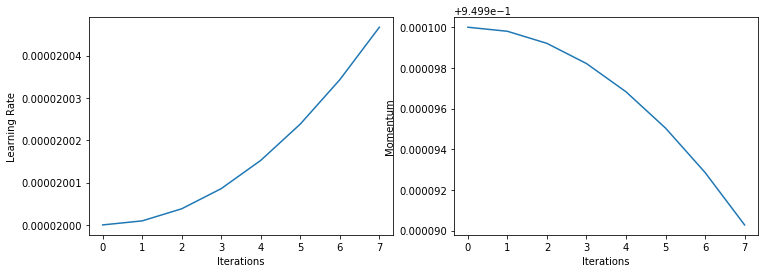

In [97]:
learn.recorder.plot_lr(True)

In [ ]:
learn.recorder.plot_losses(skip_start=500)

In [ ]:
val_contrib_preds = learn.get_preds(DatasetType.Valid)
test_contrib_preds = learn.get_preds(DatasetType.Test)

In [ ]:
val_preds = val_contrib_preds[0][:,-1].detach().numpy() * SC_STD + SC_MEAN
test_preds = test_contrib_preds[0][:,-1].detach().numpy() * SC_STD + SC_MEAN

In [ ]:
def store_submit(predictions):
    submit = pd.read_csv(DATA_PATH + 'sample_submission.csv')
    print(len(submit), len(predictions))   
    submit['scalar_coupling_constant'] = predictions
    submit.to_csv(f'mpnn-swa-v{VERSION}-idx{FOLD_ID}-submission.csv', index=False)

def store_oof(predictions, val_ids):
    oof = pd.DataFrame(predictions, columns=['scalar_coupling_constants'])
    print(oof.head())
    oof.to_csv(f'mpnn-swa-v{VERSION}-idx{FOLD_ID}-oof.csv')

In [ ]:
store_submit(test_preds)
store_oof(val_preds, val_mol_ids)